In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from matplotlib import rc
from matplotlib import pyplot as plt
from PyFin.api import makeSchedule
from alphamind.api import *
from alphamind.analysis.quantileanalysis import er_quantile_analysis

rc('font', **{'family': 'Microsoft YaHei', 'size': 10})
rc('mathtext', **{'default': 'regular'})
rc('legend', **{'frameon': False})

## 1. 数据准备
------------------

* 股票池：沪深300
* 因子：`EMA5D`
* 调仓频率：5个交易日
* 起始日：2020年1月1日
* 终止日：2020年2月21日
* 分位数：5

In [2]:
engine = SqlEngine(os.environ['DB_URI'])
universe = Universe('hs300')
factor = 'EMA5D'
freq = '10b'
start_date = '2020-01-01'
end_date = '2020-02-21'
n_bins = 5
neutralized_styles = industry_styles # risk_styles + industry_styles

dates = makeSchedule(start_date, end_date, freq, 'china.sse')
horizon = map_freq(freq)

In [3]:
%%time
factor_data = engine.fetch_factor_range(universe, factor, dates=dates)
risk_cov, risk_factors = engine.fetch_risk_model_range(universe, dates=dates)
return_data = engine.fetch_dx_return_range(universe, dates=dates, horizon=horizon)
total_data = pd.merge(factor_data, risk_factors, on=['trade_date', 'code'])
total_data = pd.merge(total_data, return_data, on=['trade_date', 'code']).dropna()

Wall time: 1.48 s


## 2. 分位数群组收益比较
-----------------------

In [4]:
total_data

,trade_date,EMA5D,code,chgPct,secShortName,srisk,BETA,MOMENTUM,SIZE,EARNYILD,...,AgriForest,CHEM,Media,IronSteel,NonBankFinan,ELECEQP,AERODEF,Conglomerates,COUNTRY,dx
0,2020-01-02,12.369556,2010000001,0.8084,浦发银行,11.256,-1.573,0.091,2.229,1.438,...,0,0,0,0,0,0,0,0,1,-0.021890
1,2020-01-02,17.593333,2010000005,0.4011,白云机场,31.901,-0.293,0.405,0.064,-0.567,...,0,0,0,0,0,0,0,0,1,0.006826
2,2020-01-02,77.804889,2010000010,-1.7651,上海机场,17.900,-1.556,0.733,1.388,-0.586,...,0,0,0,0,0,0,0,0,1,-0.051323
3,2020-01-02,1.318889,2010000011,0.7576,包钢股份,17.841,-0.676,-1.499,0.545,-0.702,...,0,0,0,1,0,0,0,0,1,-0.015151
4,2020-01-02,5.628444,2010000012,1.0753,华能国际,20.390,-2.111,-0.561,0.900,1.159,...,0,0,0,0,0,0,0,0,1,-0.017889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2020-02-21,5.716444,2010030709,-1.3605,青农商行,23.743,0.641,-1.647,-0.063,-0.006,...,0,0,0,0,0,0,0,0,1,0.001723
1196,2020-02-21,8.934889,2010030989,-0.5543,宝丰能源,22.830,-0.527,-0.799,0.592,0.306,...,0,0,0,0,0,0,0,0,1,0.183807
1197,2020-02-21,19.604889,2010031146,4.2017,红塔证券,41.036,1.805,-0.565,0.732,-1.571,...,0,0,0,0,1,0,0,0,1,0.158883
1198,2020-02-21,2.659778,2010031199,-0.7380,海油发展,21.980,-0.545,-0.857,-0.214,-0.270,...,0,0,0,0,0,0,0,0,1,-0.007462


In [5]:
neutralized_factors = neutralize(total_data[neutralized_styles].values.astype(float),
                                 total_data['EMA5D'].values,
                                 groups=total_data['trade_date'].values)
total_data['neutralized_factors'] = neutralized_factors

In [6]:
%%time

df = pd.DataFrame(columns=['q' + str(i) for i in range(1, n_bins+1)])

grouped = total_data.groupby('trade_date')
for k, g in grouped:
    er = g['neutralized_factors'].values
    dx_return = g['dx'].values
    res = er_quantile_analysis(er, n_bins=n_bins, dx_return=dx_return, de_trend=True)
    df.loc[k, :] = res

Wall time: 685 ms


<AxesSubplot:>

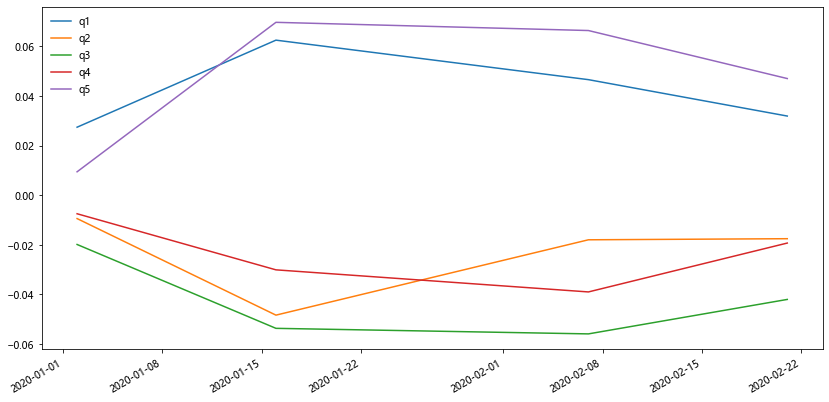

In [7]:
df.cumsum().plot(figsize=(14, 7))

<AxesSubplot:>

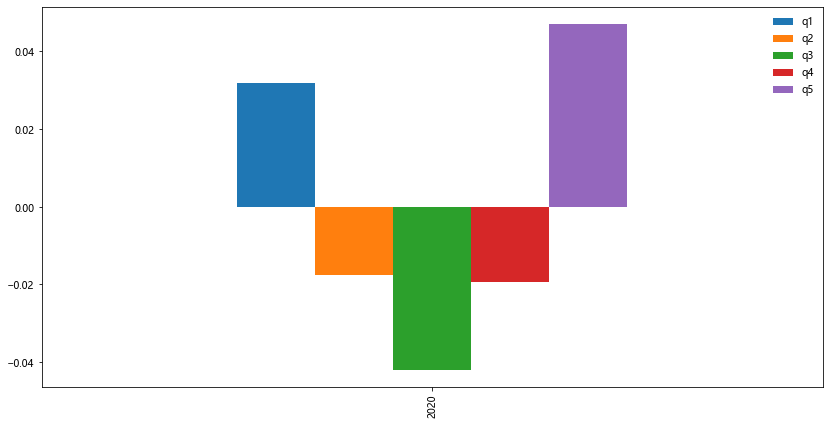

In [8]:
ret_yearly = df.groupby(df.index.year).sum()
ret_yearly.plot(kind='bar', figsize=(14, 7))

<AxesSubplot:>

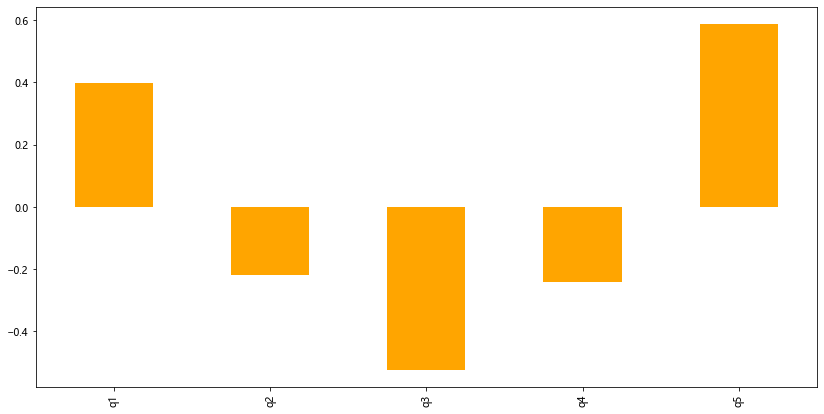

In [9]:
(df.mean() * 50).plot(kind='bar', figsize=(14, 7), color='orange')